In [1]:
import keras
import datetime
import tensorflow                       as tf
from tensorflow.keras.callbacks         import TensorBoard
from tensorflow.keras.layers            import Input, Lambda,UpSampling2D, Conv2D,Dropout,MaxPooling2D,Conv2DTranspose,concatenate,BatchNormalization, Activation
from tensorflow.keras.models            import Model
from tensorflow.keras.optimizers        import Adam,RMSprop
from keras.utils                        import plot_model
from tensorflow.keras                   import layers, models
from tensorflow.keras.losses            import mae
import sys
import os
import numpy as np
import math
import random, time
from pathlib                        import Path
from PIL                            import Image

import skimage                      as ski
from   skimage.filters              import threshold_otsu
from   skimage                      import io, color
from   skimage.color                import rgb2gray
from   skimage                      import filters
import cv2                          as cv
import matplotlib.pyplot            as plt 
import gc
import glob
from skimage                        import img_as_ubyte
from skimage                        import io
import shutil
tf.keras.backend.clear_session()

2025-05-14 21:23:20.003517: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-14 21:23:20.012447: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-14 21:23:20.024446: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-14 21:23:20.027364: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-14 21:23:20.034470: I tensorflow/core/platform/cpu_feature_guar

In [36]:
os.environ["XLA_FLAGS"] = "--xla_gpu_strict_conv_algorithm_picker=false"

### Working with ImageDataGenerator

In [3]:
#general_directory ='/home/ppgi/Trabajo/predicting-flow-patterns'
general_directory ='/home/guiomar/Desktop/CODES/predicting-flow-patterns'
n_batch=8

def dataset(directory,batch_size=n_batch):
    data = keras.utils.image_dataset_from_directory(directory,
    labels=None,
    label_mode=None,
    image_size=(128, 256),
    color_mode="grayscale",
    shuffle=False,
    batch_size=batch_size)
    return data

path_1= general_directory + '/geo_masked' + '/train'
path_2= general_directory + '/geo_masked' + '/test'
path_3= general_directory + '/geo_masked' + '/valid'

path_4= general_directory + '/mag_masked' + '/train'
path_5= general_directory + '/mag_masked' + '/test'
path_6= general_directory + '/mag_masked' + '/valid'

path_7= general_directory + '/vx_masked' + '/train'
path_8= general_directory + '/vx_masked' + '/test'
path_9= general_directory + '/vx_masked' + '/valid'

path_10= general_directory + '/vy_masked' + '/train'
path_11= general_directory + '/vy_masked' + '/test'
path_12= general_directory + '/vy_masked' + '/valid'

path_13= general_directory + '/p_masked' + '/train'
path_14= general_directory + '/p_masked' + '/test'
path_15= general_directory + '/p_masked' + '/valid'
    

In [4]:
g_train = dataset(path_1)
g_test  = dataset(path_2)
g_valid = dataset(path_3)
print('******************')
v_train = dataset(path_4)
v_test  = dataset(path_5)
v_valid = dataset(path_6)
print('******************')
vx_train = dataset(path_7)
vx_test  = dataset(path_8)
vx_valid = dataset(path_9)
print('******************')
vy_train = dataset(path_10)
vy_test  = dataset(path_11)
vy_valid = dataset(path_12)
print('******************')
p_train = dataset(path_13)
p_test = dataset(path_14)
p_valid  = dataset(path_15)

Found 5600 files.
Found 800 files.


I0000 00:00:1747272272.066360    6491 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-05-14 21:24:32.290660: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Found 1600 files.
******************
Found 5600 files.
Found 800 files.
Found 1600 files.
******************
Found 5600 files.
Found 800 files.
Found 1600 files.
******************
Found 5600 files.
Found 800 files.
Found 1600 files.
******************
Found 5600 files.
Found 800 files.
Found 1600 files.


In [5]:
# combination of output datasets
output_train = tf.data.Dataset.zip((v_train,vx_train,vy_train,p_train))
output_test = tf.data.Dataset.zip((v_test,vx_test,vy_test,p_test))
output_valid = tf.data.Dataset.zip((v_valid,vx_valid,vy_valid,p_valid))

# combination of input datasets with output datasets
final_train = tf.data.Dataset.zip((g_train,output_train))
final_test = tf.data.Dataset.zip((g_test,output_test))
final_valid = tf.data.Dataset.zip((g_valid,output_valid))

### Standarize the data

In [6]:
# Standardizing values to be in the [0, 1] range by using tf.keras.layers.Rescaling:
normalization_layer = tf.keras.layers.Rescaling(1./255)

final_train_normalized = final_train.map(lambda x, y: (normalization_layer(x), y))
final_test_normalized = final_test.map(lambda x, y: (normalization_layer(x), y))
final_valid_normalized = final_valid.map(lambda x, y: (normalization_layer(x), y))


### Hiperparámeters

In [9]:
num_epochs = 5
patience=5  # How long to wait after last time validation loss improved
LR=0.001
# Model name
model_name="U-Net"
plot_name='U-Net_Model.png'
save_in='/home/ppgi/Trabajo/Codigos_generate_data/DLCODES-VER-5'
# image dimensions
img_width             =  256   # 739   G:737
img_height            =  128   # 185
channel               =  1

In [10]:
number_of_filters = [4, 16, 32]
type_padding = 'same'
f_activation = 'relu'
f_activation_last='linear'
optimizer = RMSprop(learning_rate=LR)
#number_of_filters = [16, 32, 64, 128, 256, 512]
#number_of_filters = [64, 128, 256, 512, 1024]

### Architecture

In [11]:
def conv_block_batchnorm(filters,x):
    conv = Conv2D(filters, (3, 3), padding=type_padding)(x)
    conv= BatchNormalization()(conv)
    conv = Activation(f_activation)(conv)
    conv = Conv2D(filters, (3, 3), padding=type_padding)(conv)
    conv= BatchNormalization()(conv)
    conv = Activation(f_activation)(conv)
    return conv
    
def conv_block(filters,x):
    conv = Conv2D(filters, (3, 3), activation=f_activation, padding=type_padding)(x)
    conv = Conv2D(filters, (3, 3), activation=f_activation, padding=type_padding)(conv)
    return conv    

def encoder(x,filters):
    conv = conv_block_batchnorm(filters,x)
    downsample = MaxPooling2D((2,2))(conv)
    return conv,downsample

def decoder(x1,x2,filters,transpose=None):
    if transpose != None:
        conv_up = Conv2DTranspose(filters,(2,2),strides=(2, 2),padding=type_padding)(x1)
    else:
        conv_up = UpSampling2D((2, 2))(x1)
   
    concat=concatenate([conv_up,x2],axis = 3)
    up = conv_block(filters, concat)
    return up


In [12]:
# number_of_filters = [4, 16, 32]
def make_model():
    
    image_input = Input((img_height, img_width, channel))
    
    conv1,down_block1 = encoder (image_input, number_of_filters[0])
    conv2,down_block2 = encoder (down_block1 , number_of_filters[1])

    bottleneck = conv_block(number_of_filters[2],down_block2)

    # First decoder
    up4 = decoder(bottleneck,conv2,number_of_filters[1])
    up5 = decoder(up4,conv1,number_of_filters[0])
    v_out = Conv2D(1, (1, 1), activation=f_activation_last,name='v_output')(up5)


    # Second decoder
    up4 = decoder(bottleneck,conv2,number_of_filters[1])
    up5 = decoder(up4,conv1,number_of_filters[0])
    vx_out = Conv2D(1, (1, 1), activation=f_activation_last,name='vx_output')(up5)

    # Third decoder
    up4 = decoder(bottleneck,conv2,number_of_filters[1])
    up5 = decoder(up4,conv1,number_of_filters[0])
    vy_out = Conv2D(1, (1, 1), activation=f_activation_last,name='vy_output')(up5)

    # Fourth decoder
    up4 = decoder(bottleneck,conv2,number_of_filters[1])
    up5 = decoder(up4,conv1,number_of_filters[0])
    p_out = Conv2D(1, (1, 1), activation=f_activation_last,name='p_output')(up5)
    
     # construct model
    model =  keras.Model(inputs=image_input, outputs=[v_out,vx_out,vy_out,p_out],name= model_name)
    
    model.summary()
    
    model.compile(optimizer=optimizer, 
              loss = {  'v_output': 'mean_squared_error' ,
                        'vx_output': 'mean_squared_error' , 
                        'vy_output': 'mean_squared_error',
                        'p_output': 'mean_squared_error'},
              
              metrics={ 'v_output': ['mae'],
                        'vx_output': ['mae'],
                        'vy_output': ['mae'],
                        'p_output': ['mae'] })
    return model    

In [45]:
'''
#number_of_filters = [16, 32, 64, 128, 256, 512]
def make_model():
    
    image_input = Input((img_height, img_width, channel))
    
    conv1,down_block1 = encoder (image_input, number_of_filters[0])
    conv2,down_block2 = encoder (down_block1 , number_of_filters[1])
    conv3,down_block3 = encoder (down_block2, number_of_filters[2])
    conv4,down_block4 = encoder (down_block3, number_of_filters[3])
    conv5,down_block5 = encoder (down_block4, number_of_filters[4])
    bottleneck = conv_block(number_of_filters[5],down_block5)
    # First decoder
    up6 = decoder(bottleneck,conv5,number_of_filters[4])
    up7 = decoder(up6,conv4,number_of_filters[3])
    up8 = decoder(up7,conv3,number_of_filters[2])
    up9 = decoder(up8,conv2,number_of_filters[1])
    up10 = decoder(up9,conv1,number_of_filters[0])
    v_out = Conv2D(1, (1, 1), activation=f_activation_last,name='v_output')(up10)

    # Second decoder
    up6 = decoder(bottleneck,conv5,number_of_filters[4])
    up7 = decoder(up6,conv4,number_of_filters[3])
    up8 = decoder(up7,conv3,number_of_filters[2])
    up9 = decoder(up8,conv2,number_of_filters[1])
    up10 = decoder(up9,conv1,number_of_filters[0])
    vx_out = Conv2D(1, (1, 1), activation=f_activation_last,name='vx_output')(up10)

    # Third decoder
    up6 = decoder(bottleneck,conv5,number_of_filters[4])
    up7 = decoder(up6,conv4,number_of_filters[3])
    up8 = decoder(up7,conv3,number_of_filters[2])
    up9 = decoder(up8,conv2,number_of_filters[1])
    up10 = decoder(up9,conv1,number_of_filters[0])
    vy_out = Conv2D(1, (1, 1), activation=f_activation_last,name='vy_output')(up10)

    # Fourth decoder
    up6 = decoder(bottleneck,conv5,number_of_filters[4])
    up7 = decoder(up6,conv4,number_of_filters[3])
    up8 = decoder(up7,conv3,number_of_filters[2])
    up9 = decoder(up8,conv2,number_of_filters[1])
    up10 = decoder(up9,conv1,number_of_filters[0])
    p_out = Conv2D(1, (1, 1), activation=f_activation_last,name='p_output')(up10)

    # construct model
    model =  keras.Model(inputs=image_input, outputs=[v_out,vx_out,vy_out,p_out],name= model_name)
    
    model.summary()
    
    model.compile(optimizer=optimizer, 
              loss = {  'v_output': 'mean_squared_error' ,
                        'vx_output': 'mean_squared_error' , 
                        'vy_output': 'mean_squared_error',
                        'p_output': 'mean_squared_error'},
              
              metrics={ 'v_output': ['mae'],
                        'vx_output': ['mae'],
                        'vy_output': ['mae'],
                        'p_output': ['mae'] })
    return model             
'''    

"\n#number_of_filters = [16, 32, 64, 128, 256, 512]\ndef make_model():\n    \n    image_input = Input((img_height, img_width, channel))\n    \n    conv1,down_block1 = encoder (image_input, number_of_filters[0])\n    conv2,down_block2 = encoder (down_block1 , number_of_filters[1])\n    conv3,down_block3 = encoder (down_block2, number_of_filters[2])\n    conv4,down_block4 = encoder (down_block3, number_of_filters[3])\n    conv5,down_block5 = encoder (down_block4, number_of_filters[4])\n    bottleneck = conv_block(number_of_filters[5],down_block5)\n    # First decoder\n    up6 = decoder(bottleneck,conv5,number_of_filters[4])\n    up7 = decoder(up6,conv4,number_of_filters[3])\n    up8 = decoder(up7,conv3,number_of_filters[2])\n    up9 = decoder(up8,conv2,number_of_filters[1])\n    up10 = decoder(up9,conv1,number_of_filters[0])\n    v_out = Conv2D(1, (1, 1), activation=f_activation_last,name='v_output')(up10)\n\n    # Second decoder\n    up6 = decoder(bottleneck,conv5,number_of_filters[4])\

In [13]:
M=make_model()

Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 256,  │         40 │ input_layer[0][0] │
│                     │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 256,  │         16 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 128, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 256,  │        148 │ activation[0][0]  │
│                     │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 256,  │         16 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 128, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 128,   │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 128,   │        592 │ max_pooling2d[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 128,   │         64 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 64, 128,   │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 128,   │      2,320 │ activation_2[0][… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 128,   │         64 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 64, 128,   │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 64,    │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 64,    │      4,640 │ max_pooling2d_1[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 64,    │      9,248 │ conv2d_4[0][0]  

 Total params: 57,648 (225.19 KB)

 Trainable params: 57,568 (224.88 KB)

 Non-trainable params: 80 (320.00 B)

In [14]:
print("Starting trainig")

history = M.fit(final_train,epochs=num_epochs,validation_data = final_valid)

Starting trainig
Epoch 1/5


2025-05-14 21:26:47.049156: E tensorflow/core/util/util.cc:131] oneDNN supports DT_INT32 only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


700/700 ━━━━━━━━━━━━━━━━━━━━ 95s 132ms/step - loss: 5603.3477 - p_output_loss: 1225.0386 - p_output_mae: 25.1907 - v_output_loss: 2374.0728 - v_output_mae: 42.8141 - vx_output_loss: 393.3915 - vx_output_mae: 13.8106 - vy_output_loss: 1610.8436 - vy_output_mae: 25.3243 - val_loss: 4188.9912 - val_p_output_loss: 838.9456 - val_p_output_mae: 19.8293 - val_v_output_loss: 2313.4158 - val_v_output_mae: 42.3040 - val_vx_output_loss: 380.0261 - val_vx_output_mae: 13.7702 - val_vy_output_loss: 656.6032 - val_vy_output_mae: 24.0164
Epoch 2/5
700/700 ━━━━━━━━━━━━━━━━━━━━ 95s 135ms/step - loss: 2975.4797 - p_output_loss: 923.6992 - p_output_mae: 21.1338 - v_output_loss: 1692.0708 - v_output_mae: 32.7411 - vx_output_loss: 206.1069 - vx_output_mae: 9.7160 - vy_output_loss: 153.6030 - vy_output_mae: 9.9112 - val_loss: 2882.7410 - val_p_output_loss: 837.7029 - val_p_output_mae: 17.7850 - val_v_output_loss: 488.7260 - val_v_output_mae: 16.8684 - val_vx_output_loss: 477.7234 - val_vx_output_mae: 16.8580

### Evaluating

In [ ]:
results = M.evaluate(final_test_normalized) 
print("Evaluation results:")
for name, value in zip(M.metrics_names, results):
    print(f"{name}: {value:.4f}")

100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 16266.7236 - p_output_loss: 2339.1213 - p_output_mae: 35.5871 - v_output_loss: 2354.5422 - v_output_mae: 42.6520 - vx_output_loss: 2305.9290 - vx_output_mae: 42.2886 - vy_output_loss: 9267.1318 - vy_output_mae: 93.5709
Evaluation results:
loss: 16374.6162
compile_metrics: 2359.4302
v_output_loss: 2309.7998
vx_output_loss: 9261.1631
vy_output_loss: 2444.2241
p_output_loss: 36.1057


### Prediction

In [55]:
def plot_predictions(y_true,y_pred):
    
    k_example = random.randint(0, n_batch-1)
    vtrue=y_true[0][k_example]
    vxtrue=y_true[1][k_example]
    vytrue=y_true[2][k_example]
    ptrue=y_true[3][k_example]

    vpred=y_pred[0][k_example]
    vxpred=y_pred[1][k_example]
    vypred=y_pred[2][k_example]
    ppred=y_pred[3][k_example]

    error_v = np.abs(vpred - vtrue)
    error_vx = np.abs(vxpred - vxtrue)
    error_vy = np.abs(vypred - vytrue)
    error_p  = np.abs(ppred- ptrue)

    # Plot
    fig, axes = plt.subplots(4, 3, figsize=(16, 12))

    titles = [ 'V true', 'V pred', 'Absolute error',
               'Vx true', 'Vx pred', '',
               'Vy true', 'Vy pred', '',
               'P true', 'P pred', '']
    
    axes[0, 0].imshow(vtrue, cmap='gray'); axes[0, 0].set_title(titles[0])
    axes[0, 1].imshow(vpred, cmap='gray'); axes[0, 1].set_title(titles[1])
    Ev=axes[0, 2].imshow(error_v, cmap='gray'); axes[0, 2].set_title(titles[2])
    fig.colorbar(Ev, ax=axes[0,2], fraction=0.046, pad=0.01)

    axes[1, 0].imshow(vxtrue, cmap='gray'); axes[1, 0].set_title(titles[3])
    axes[1, 1].imshow(vxpred, cmap='gray'); axes[1, 1].set_title(titles[4])
    Evx=axes[1, 2].imshow(error_vx, cmap='gray')
    fig.colorbar(Evx, ax=axes[1,2], fraction=0.046, pad=0.01)

    axes[2, 0].imshow(vytrue, cmap='gray'); axes[2, 0].set_title(titles[6])
    axes[2, 1].imshow(vypred, cmap='gray'); axes[2, 1].set_title(titles[7])
    Evy=axes[2, 2].imshow(error_vy, cmap='gray')
    fig.colorbar(Evy, ax=axes[2,2], fraction=0.046, pad=0.01)

    axes[3, 0].imshow(ptrue, cmap='gray'); axes[3, 0].set_title(titles[9])
    axes[3, 1].imshow(ppred, cmap='gray'); axes[3, 1].set_title(titles[10])
    Ep=axes[3, 2].imshow(error_p, cmap='gray')
    fig.colorbar(Ep, ax=axes[3,2], fraction=0.046, pad=0.01)


    for ax in axes.flat:
        ax.axis('off')    

    plt.tight_layout()
    plt.show()        

    

In [56]:
def show_predictions(model):
    number_batches = tf.data.experimental.cardinality(g_test).numpy()
    N = random.randint(0, number_batches) #get batch number N
    for i,(g_batch, y_true) in enumerate(final_test_normalized):
        if i == N:
            break
    y_pred = model.predict(g_batch)
    plot_predictions(y_true,y_pred)    

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


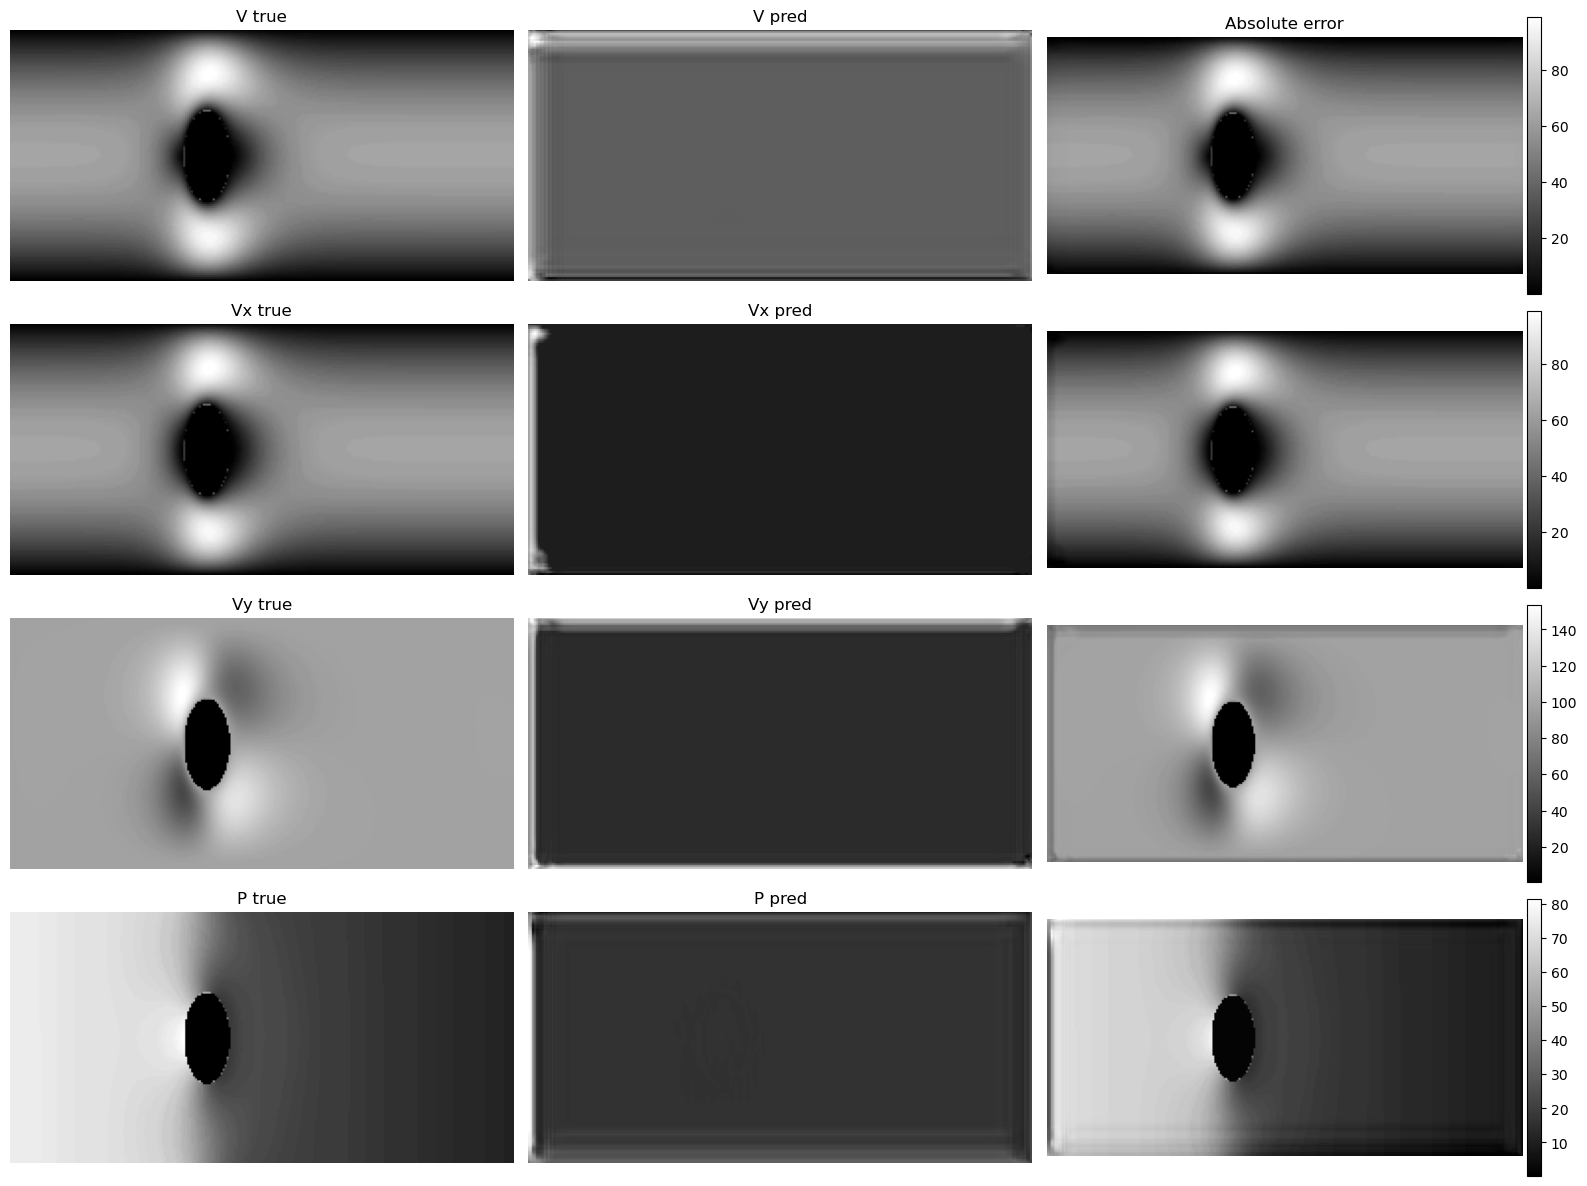

In [59]:
show_predictions(M)